In [1]:
import numpy as np
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver
from devito import clear_cache
from devito.logger import set_log_level
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501

# Time axis

time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .070

In [4]:
# Fine grid model
c0 = 1.500
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(1.0, 1.0), shape=(401, 401), nbpml=40, dtype=np.float64)


In [5]:
# Source and receiver
src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.data[:] = src.data[:] / c0**2
# Define receiver geometry (spread across x, just below surface)
rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
rec.coordinates.data[:, 0] = 260.
rec.coordinates.data[:, 1] = 260.

# Reference solution for numerical convergence

In [6]:
solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=40, dse=None, dle=None)

ref_rec, ref_u, _ = solver.forward()

GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-3t3qw630/625ad438fd121a644519d4475d5c242bddfd0a8a.c [0.28 s]
Section section_1<1499,1> with OI=1.59 computed in 0.001 s [0.19 GFlops/s]
Section section_2<1499,1> with OI=2.48 computed in 0.001 s [0.26 GFlops/s]
Section main<1499,441,441> with OI=6.54 computed in 31.744 s [1.72 GFlops/s, 0.01 GPts/s]


# Analytical solution for comparison with the reference numerical solution

put math

In [7]:
sx = src.coordinates.data[0, 0]
sz = sx

rx = sx + 60.
rz = sz + 60.

G    = time * 0.
r    = np.sqrt((sx - rx) ** 2 + (sz - rz) ** 2)

for it in range(nt): # Calculate Green's function
    if ((time[it] - r / c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2)) \
        * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
Gc   = np.convolve(G, src.data[:, 0] * .1 * c0**2)
Gc   = Gc[0:nt]

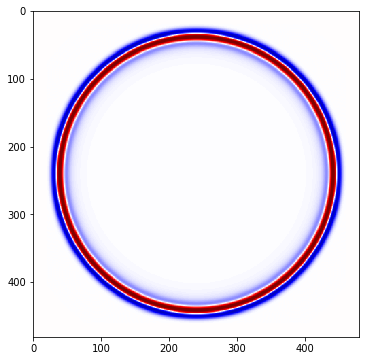

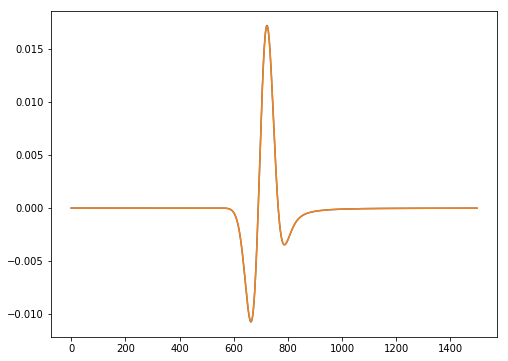

In [8]:
plt.figure()
plt.imshow(ref_u.data[1,:,:], vmin=-.01, vmax=.01, cmap="seismic")
plt.figure()
plt.plot(ref_rec.data[:-1, 0])
plt.plot(Gc[:-1])
plt.show()

In [9]:
np.linalg.norm(Gc[:-1] - ref_rec.data[:-1, 0], np.inf)

0.00015811568890275983

We have a correct refernce solution we can use for space discretization analysis

In [10]:
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        clear_cache()
        model = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn),
                           nbpml=40, dtype=np.float64)
        src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
        src.coordinates.data[0, :] = 200.
        src.data[:] = src.data[:] / (c0*h)**2

        # Define receiver geometry (spread across x, just below surface)
        rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
        rec.coordinates.data[:, 0] = 260.
        rec.coordinates.data[:, 1] = 260.
        solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=spc, dse=None, dle=None)

        loc_rec, loc_u, summary = solver.forward()
        # minus error in time
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:] - ref_rec.data[:], np.inf)
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (201, 201) grid points the error is 0.00598463573889 for 4.145152 runtime
starting space order 2 with (161, 161) grid points the error is 0.00928890236936 for 2.982546 runtime
starting space order 2 with (101, 101) grid points the error is 0.0166404546886 for 1.723837 runtime
starting space order 4 with (201, 201) grid points the error is 0.000359263762909 for 4.733586 runtime
starting space order 4 with (161, 161) grid points the error is 0.000906708861596 for 3.108916 runtime
starting space order 4 with (101, 101) grid points the error is 0.00534012870618 for 1.709402 runtime
starting space order 6 with (201, 201) grid points the error is 3.62307131393e-05 for 4.214557 runtime
starting space order 6 with (161, 161) grid points the error is 0.000136158182613 for 3.827039 runtime
starting space order 6 with (101, 101) grid points the error is 0.00194734735372 for 2.002122 runtime
starting space order 8 with (201, 201) grid points the error is 6.49642809586e-

In [11]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, 5):
        plot.add_line(list(errorl2[i, :]), list(timing[i, :]), label=('order %s' % orders[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

OpesciBench: Plotting ./MyPrettyPicture.pdf 


In [12]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in dx]
        theory = [errorl2[i, 2]*th/theory[2] for th in theory]
        plot.add_line([sc for sc in dx], list(errorl2[i, :]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for sc in dx], style=stylel[i])
        plot.add_line([sc for  sc in dx], list(theory), label=('Theoretical order %s' % orders[i]), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

OpesciBench: Plotting ./MyPrettyPicture3.pdf 
